In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from matplotlib import colors
from scipy import stats

# --------------- IMPORTING THE DATA --------------- #
dir = './output_new3/tick_res'
# Evacuation Data
evacfiles = [f"{dir}/0.1/gy-evac tick_res-table.csv", f"{dir}/0.2/gy-evac tick_res-table.csv", f"{dir}/0.3/gy-evac tick_res-table.csv", f"{dir}/0.4/gy-evac tick_res-table.csv", f"{dir}/0.5/gy-evac tick_res-table.csv", f"{dir}/0.6/gy-evac tick_res-table.csv", f"{dir}/0.7/gy-evac tick_res-table.csv", f"{dir}/0.8/gy-evac tick_res-table.csv", f"{dir}/0.9/gy-evac tick_res-table.csv", f"{dir}/1.0/gy-evac tick_res-table.csv"]
evacdata_list = [pd.read_csv(file, skiprows=6) for file in evacfiles]
# concatenate the dataframes
evacdata = pd.concat(evacdata_list, ignore_index=True).sort_values(by=['tick-time-in-mins', 'ticks']).reset_index(drop=True)
# renaming the column to something that isn't cursed
evacdata.rename(columns={'[run number]': 'run_number'}, inplace=True)
evacdata.rename(columns={'initial-people': 'population'}, inplace=True)
evacdata.columns = evacdata.columns.str.replace('-', '_')
# calculate time in minutes
evacdata['time_minutes'] = evacdata['ticks'] * evacdata['tick_time_in_mins']
evacdata['evacuated_perc'] = evacdata['get_no_evacuated'] / evacdata['population'] * 100
evacdata['evacuating_perc'] = evacdata['get_no_evacuating'] / evacdata['population'] * 100

# Journey Time Data
jm_files = [f"{dir}/0.1/jm__p15000_evp0.3_tick0.1_max_walk_d1_term_d0.3_interval30.csv", f"{dir}/0.2/jm__p15000_evp0.3_tick0.2_max_walk_d1_term_d0.3_interval30.csv", f"{dir}/0.3/jm__p15000_evp0.3_tick0.3_max_walk_d1_term_d0.3_interval30.csv", f"{dir}/0.4/jm__p15000_evp0.3_tick0.4_max_walk_d1_term_d0.3_interval30.csv", f"{dir}/0.5/jm__p15000_evp0.3_tick0.5_max_walk_d1_term_d0.3_interval30.csv", f"{dir}/0.6/jm__p15000_evp0.3_tick0.6_max_walk_d1_term_d0.3_interval30.csv", f"{dir}/0.7/jm__p15000_evp0.3_tick0.7_max_walk_d1_term_d0.3_interval30.csv", f"{dir}/0.8/jm__p15000_evp0.3_tick0.8_max_walk_d1_term_d0.3_interval30.csv", f"{dir}/0.9/jm__p15000_evp0.3_tick0.9_max_walk_d1_term_d0.3_interval30.csv", f"{dir}/1.0/jm__p15000_evp0.3_tick1.0_max_walk_d1_term_d0.3_interval30.csv"]
journey_metrics_list = [pd.read_csv(file) for file in jm_files]
# Extract tick number from file names and add as a column to each dataframe
for i, file in enumerate(jm_files):
    tick_number = float(file.split('_')[6][4:])
    journey_metrics_list[i]['tick_time_in_mins'] = tick_number
# Concatenate the dataframes
journey_metrics = pd.concat(journey_metrics_list, ignore_index=True).sort_values(by=['tick_time_in_mins', 'start_tick']).reset_index(drop=True)
# calculate time in minutes
journey_metrics['start_time_minutes'] = journey_metrics['start_tick'] * journey_metrics['tick_time_in_mins']

# calculate normalised journey time
journey_metrics['normalised_journey_time'] = journey_metrics['actual_time'] / journey_metrics['ideal_time']

# calculate the mean normalised journey time every 30 minutes for each run
# Bin the start_tick at intervals of 120 (corresponding to 30 minutes)
journey_metrics['start_time_bin'] = pd.cut(journey_metrics['start_time_minutes'], bins=np.arange(-15, journey_metrics['start_tick'].max() + 45, 30))
# Calculate the mean normalised journey time for each bin
mean_normalised_journey_time_per_bin = journey_metrics.groupby('start_time_bin')['normalised_journey_time'].mean().reset_index()
# Calculate the mean normalised journey time for each bin for each run
mean_normalised_journey_time_per_bin_per_run = journey_metrics.groupby(['tick_time_in_mins', 'start_time_bin'])['normalised_journey_time'].mean().reset_index()

In [33]:
evacdata.head()

,run_number,terminate_evac_distance_km,population,max_walking_distance_km,warning_interval_time_mins,evacuation_probability,tick_time_in_mins,over_break_probability,[step],ticks,get_no_active_cars,get_no_walking,get_no_evacuating,get_no_evacuated,get_no_in_cars,get_avg_no_people_per_car,time_minutes,evacuated_perc,evacuating_perc
0,1,0.3,15000,1,30,0.3,0.1,0,0,0,0,0,0,0,0,0.000000,0.0,0.00,0.000000
1,1,0.3,15000,1,30,0.3,0.1,0,1,1,1094,464,4468,12,4004,3.659963,0.1,0.08,29.786667
2,1,0.3,15000,1,30,0.3,0.1,0,2,2,1094,464,4468,12,4004,3.659963,0.2,0.08,29.786667
3,1,0.3,15000,1,30,0.3,0.1,0,3,3,1094,464,4468,12,4004,3.659963,0.3,0.08,29.786667
4,1,0.3,15000,1,30,0.3,0.1,0,4,4,1094,464,4468,12,4004,3.659963,0.4,0.08,29.786667


In [34]:
evacdata['tick_time_in_mins'].unique()

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [37]:
journey_metrics['tick_time_in_mins'].unique()

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

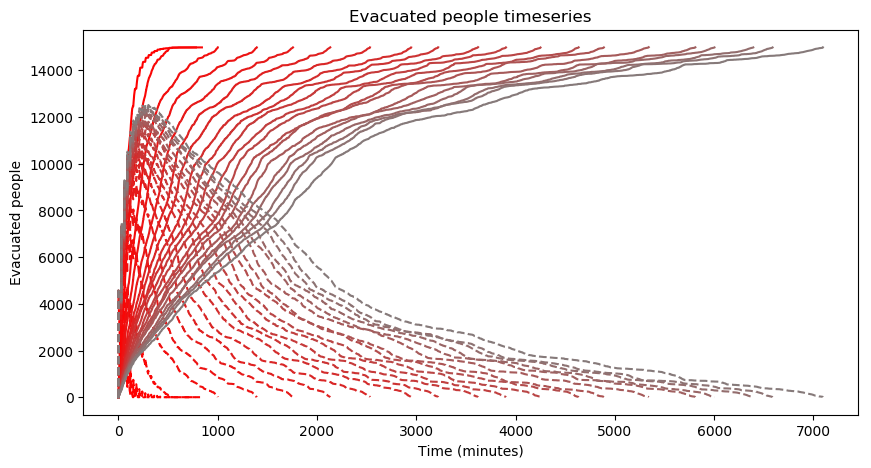

In [5]:
# NORMALISED JOURNEY TIMES TIME SERIES WITH MEAN AND STANDARD DEVIATION

fig, ax = plt.subplots(figsize=(10, 5))

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(colors.to_rgb(c1))
    c2=np.array(colors.to_rgb(c2))
    return colors.to_hex((1-mix)*c1 + mix*c2)

c1='red' 
c2='gray'
n = len(list(evacdata['tick_time_in_mins'].unique()))

# Plot each run
for i, ticktime in enumerate(evacdata['tick_time_in_mins'].unique()):
    run_data = evacdata[evacdata['tick_time_in_mins'] == ticktime]
    plt.plot(run_data["time_minutes"], run_data['get_no_evacuated'], color=colorFader(c1,c2,i/n))
    plt.plot(run_data["time_minutes"], run_data['get_no_evacuating'], linestyle='--', color=ax.get_lines()[-1].get_color())

handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles[::2], labels[::2])
ax.set_title('Evacuated people timeseries')
ax.set_ylabel('Evacuated people')
ax.set_xlabel('Time (minutes)')

plt.show()

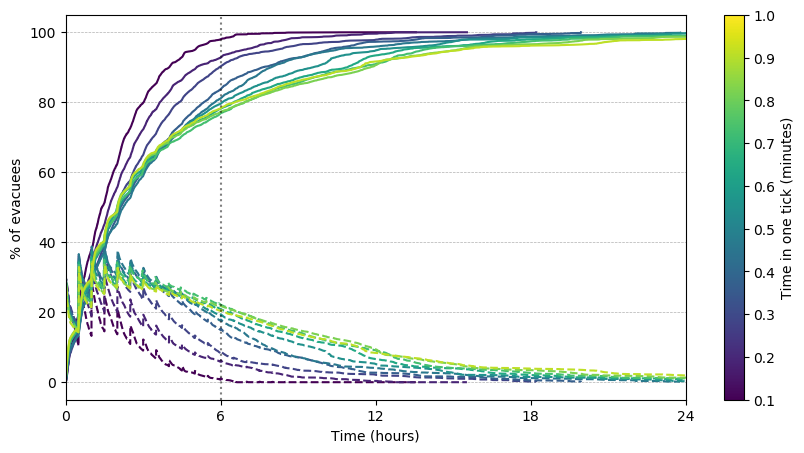

<Figure size 640x480 with 0 Axes>

In [63]:
# NORMALISED JOURNEY TIMES TIME SERIES WITH MEAN AND STANDARD DEVIATION

fig, ax = plt.subplots(figsize=(10, 5))

n = len(list(evacdata['tick_time_in_mins'].unique()))

# Plot each run
for i, ticktime in enumerate(evacdata['tick_time_in_mins'].unique()):
    run_data = evacdata[evacdata['tick_time_in_mins'] == ticktime]
    color = plt.cm.viridis(i / n)
    plt.plot(run_data["time_minutes"]/60, run_data['evacuated_perc'], color=color)
    plt.plot(run_data["time_minutes"]/60, run_data['evacuating_perc'], linestyle='--', color=ax.get_lines()[-1].get_color())

sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=evacdata['tick_time_in_mins'].min(), vmax=evacdata['tick_time_in_mins'].max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Time in one tick (minutes)')

handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles[::2], labels[::2])
ax.set_ylabel('% of evacuees')
ax.set_xlabel('Time (hours)')
ax.set_xlim(0, 5000)
ax.yaxis.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.axvline(x=6, color='k', linestyle='dotted', alpha=0.5)
ax.set_xticks([0, 6, 12, 18, 24])
ax.set_xlim(0, 24)


plt.show()
plt.savefig('./figures_v02/evac_timeseries_tickres.png')

^^ Evacuated people (solid lines) and evacuating people (dashed lines) over time. The color indicates the tick time in minutes and varies from red (0.05, the lowest value) to grey (1.0, the highest value) at intervals of 0.05.

/home/amcquaid139/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


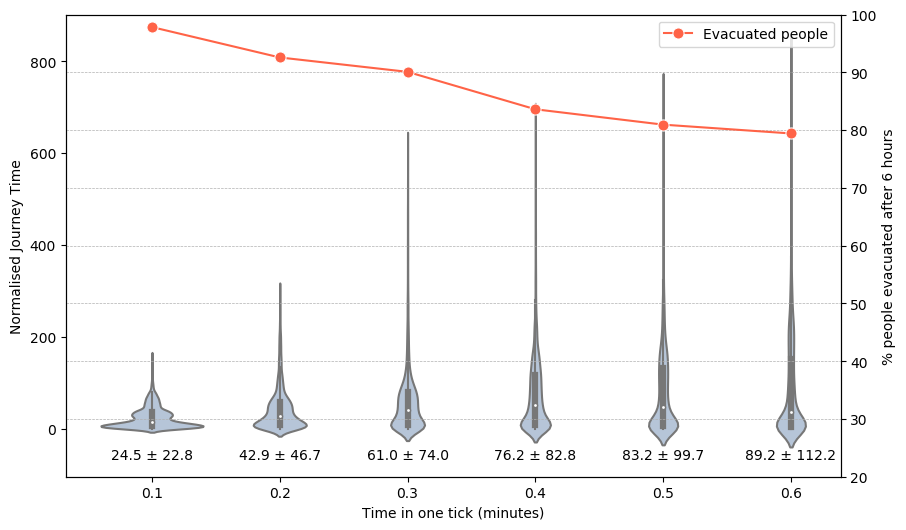

In [65]:
evacdata['tick_time_in_mins_adj'] = evacdata['tick_time_in_mins'] * 10 - 1
evacdata['evacuated_perc'] = evacdata['get_no_evacuated'] / evacdata['population'] * 100
fig, ax = plt.subplots(figsize=(10, 6))

sns.violinplot(data=journey_metrics[journey_metrics['tick_time_in_mins'].isin([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])], x='tick_time_in_mins', y="normalised_journey_time", color='lightsteelblue', ax=ax, label='Normalised Journey Time')
ax.set_ylabel('Normalised Journey Time')

# Get the x positions of the violin plots
x_positions = [patch.get_x() + patch.get_width() / 2 for patch in ax.patches]
ax.set_xlabel('Time in one tick (minutes)')

ax2 = ax.twinx()
sns.lineplot(data=evacdata[evacdata['time_minutes'] == 360][evacdata['tick_time_in_mins'].isin([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])], x='tick_time_in_mins_adj', y='evacuated_perc', color='tomato', ax=ax2, markers=True, marker='o', markersize=8, label='Evacuated people')

ax2.set_ylabel('% people evacuated after 6 hours')

# Create a combined legend
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')
ax2.set_ylim(20, 100)

# Calculate mean and standard deviation for each violin
means = journey_metrics[journey_metrics['tick_time_in_mins'].isin([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])].groupby('tick_time_in_mins')['normalised_journey_time'].mean()
stds = journey_metrics[journey_metrics['tick_time_in_mins'].isin([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])].groupby('tick_time_in_mins')['normalised_journey_time'].std()

# Offset the start of the y axis to make room for annotations
ax.set_ylim(bottom=ax.get_ylim()[0] - 20)

# Annotate mean and standard deviation
for i, evp in enumerate(means.index):
    mean = means[evp]
    std = stds[evp]
    if i != 6:
        ax.text(i, -65, f'{mean:.1f} ± {std:.1f}', horizontalalignment='center', size='small', color='black', fontsize=10)
    else:
        ax.text(i-0.1, -3, f'{mean:.1f} ± {std:.1f}', horizontalalignment='center', size='small', color='black', fontsize=10)

ax2.yaxis.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('./figures_v02/njt_evac_violin_tickres.png')

In [15]:
journey_metrics['tick_time_in_mins'].unique()

array([0.])

In [36]:
journey_metrics.groupby('tick_time_in_mins')['normalised_journey_time'].mean()

tick_time_in_mins
0.25    67.175778
0.35    72.200806
0.45    73.567120
0.55    73.415599
0.65    74.510643
0.75    74.850415
0.85    75.555314
0.95    76.483334
Name: normalised_journey_time, dtype: float64

    tick_time_in_mins  get_no_evacuated
0                0.05              7975
1                0.10              9422
2                0.15              8748
3                0.20              8542
4                0.25              7860
5                0.30              7699
6                0.35              7700
7                0.40              7308
8                0.45              7255
9                0.50              7296
10               0.55              7260
11               0.60              7090
12               0.65              7135
13               0.70              7117
14               0.75              7015
15               0.80              7083
16               0.85              7025
17               0.90              7054
18               0.95              7026
19               1.00              6925


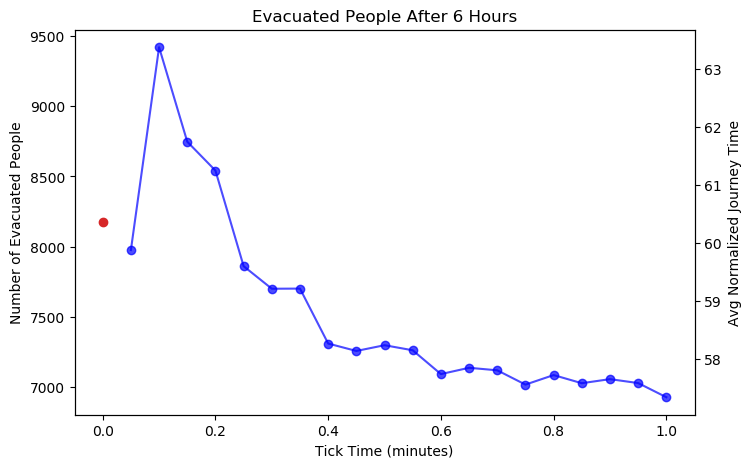

mean    7526.750000
std      680.206693
max     9422.000000
min     6925.000000
skew       1.499952
Name: get_no_evacuated, dtype: float64


In [6]:
# get number of people evacuated after 6 hours
evacuated_at_6hours = evacdata[evacdata['ticks'] == 1440].groupby('tick_time_in_mins')['get_no_evacuated'].sum().reset_index()
print(evacuated_at_6hours)
# get the average normalised journey time over 6 hours
av_norm_journey_time = journey_metrics.groupby('tick_time_in_mins')['normalised_journey_time'].mean()

fig, ax = plt.subplots(figsize=(8, 5))
# ax.hist(evacuated_at_6hours['get_no_evacuated'], bins=10, density=True, alpha=0.6, color='g')
ax.plot(evacuated_at_6hours['tick_time_in_mins'], evacuated_at_6hours['get_no_evacuated'], marker='o', color='b', alpha=0.7)
ax.set_title('Evacuated People After 6 Hours')
ax.set_ylabel('Number of Evacuated People')
ax.set_xlabel('Tick Time (minutes)')


ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Avg Normalized Journey Time')  # we already handled the x-label with ax1
ax2.plot(av_norm_journey_time, color='tab:red', marker='o')
plt.show()

evacuated_stats = evacuated_at_6hours['get_no_evacuated'].agg(['mean', 'std', 'max', 'min'])
evacuated_stats['skew'] = stats.skew(evacuated_at_6hours['get_no_evacuated'])
print(evacuated_stats)

### INTERPRETATION

- the results change significantly with increasing tick time
- the number of people evacuated after 6 hours is decreases rapidly when tick time > 0.15
- the average normalised journey time increases rapidly after tick time > 0.25
- after this the change levels off and they increase (decrease) more gradually for number of people evacuated after 6 hours (6 hour average normalised journey time). 